INTRODUCTION (Yashwanth Goduguchintha)


Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores.


Data Description
Id - an Id that represents a (Store, Date) duple within the test set
Store - a unique Id for each store
Sales - the turnover for any given day (this is what you are predicting)
Customers - the number of customers on a given day
Open - an indicator for whether the store was open: 0 = closed, 1 = open
StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
StoreType - differentiates between 4 different store models: a, b, c, d
Assortment - describes an assortment level: a = basic, b = extra, c = extended
CompetitionDistance - distance in meters to the nearest competitor store
CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
Promo - indicates whether a store is running a promo on that day
Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

APRROACH

Data Exploration: load and check missing value,
Data Visualization: plot ECDF, distribution,
Data Manipulation: change data types, impute data, create new features,
Time Series extensive Analysis: observe data distribtion over time, seasonal decomposition, plot ACF and PACF
Data Modeling: Compare AR, ARMA, SARIMA, Prophet Facebook models and multiple traditional ML algorithms regressions

 Data Processing

In [6]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:

import numpy as np
import pandas as pd
from pandas import datetime

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
import matplotlib.gridspec as gridspec
from IPython.display import display
%matplotlib inline

# Data Modeling
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA,ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima # for determining ARIMA orders


from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import lightgbm

# Data Evaluation
from sklearn.metrics import mean_squared_error

# Statistics
from statsmodels.distributions.empirical_distribution import ECDF

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Warning ignore
import warnings
warnings.filterwarnings("ignore")

DATA EXPLORATION

In [16]:
train = pd.read_csv("/content/train.csv")
store = pd.read_csv("/content/store.csv")
test = pd.read_csv("/content/test.csv", parse_dates = True, index_col = 'Date')

In [17]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [18]:
# Change datatype of InvoiceDate as datetime type
train['Date'] = pd.to_datetime(train['Date'])

In [19]:
# data extraction
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['WeekOfYear'] = train['Date'].dt.weekofyear

test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear

In [20]:
#Observation:
#On average customers spend about 9.50$ per day.

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

Observation:
About 20% of data has zero amount of sales/customers probably due to the fact that the store is closed for state holidays or school holidays

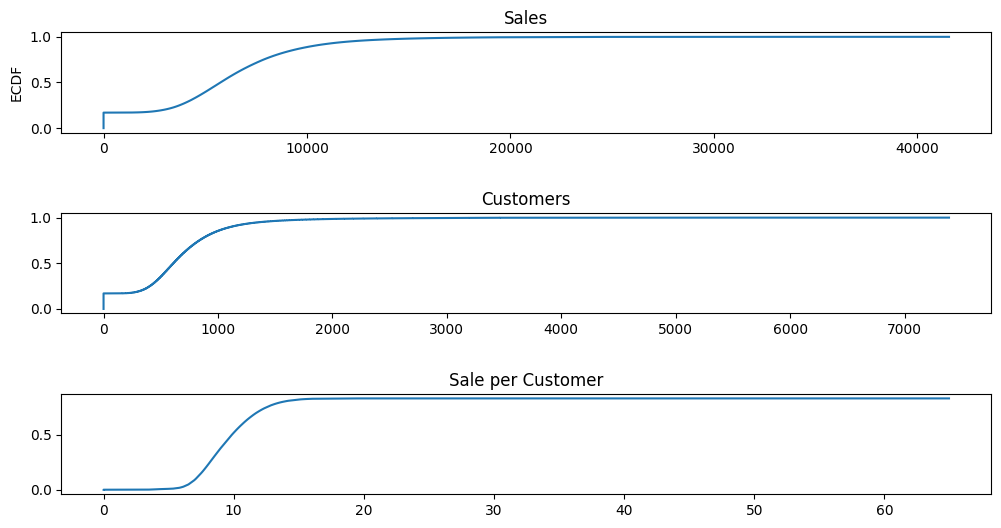

In [21]:
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.title('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.title('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.title('Sale per Customer');
plt.subplots_adjust(hspace = 0.8)

<Axes: xlabel='Sales', ylabel='Density'>

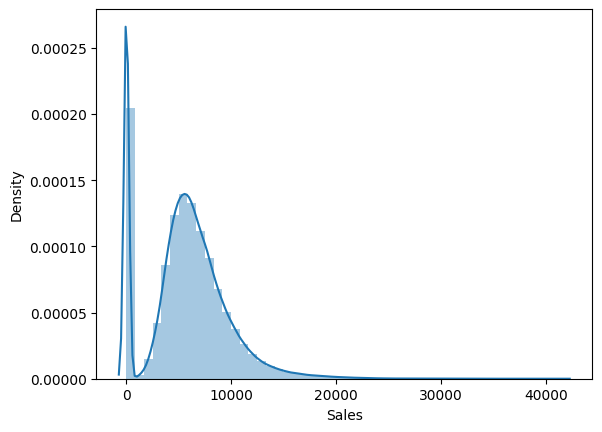

In [22]:
sns.distplot(train['Sales'])

Observation:

172817 closed stores with 0 sales.
52 store opened but without sales.
We just keep opened stores with sales for analysis.*italicised text*

In [23]:
# Closed Stores with zero sales
train[(train.Open == 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
291,292,5,2015-07-31,0,0,0,1,0,1,2015,7,31,31,NaN
875,876,5,2015-07-31,0,0,0,1,0,1,2015,7,31,31,NaN
1406,292,4,2015-07-30,0,0,0,1,0,1,2015,7,30,31,NaN
1990,876,4,2015-07-30,0,0,0,1,0,1,2015,7,30,31,NaN
2521,292,3,2015-07-29,0,0,0,1,0,1,2015,7,29,31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1,NaN
1017205,1112,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1,NaN


In [24]:
# Opened stores with zero sales
len(train[(train.Open == 1) & (train.Sales == 0)])

54

In [25]:
# Closed stores and days which didn't have any sales won't be counted into the forecasts.
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,8.626118


Filling Missing Values

In [26]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [27]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [28]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [29]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [30]:
# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

test_store = pd.merge(test, store, how = 'inner', on = 'Store')

train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


Store Type

Observation:
StoreType B has the highest average of Sales among all others, however we have much less data for it
Clearly, StoreType A come as first, StoreType D goes on the second place in both Sale and Customers

In [31]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [32]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


Observation:
Clearly any store with promotion attract more customers, leading to higher sales.
Interestingly, sale escalates toward the end of the year, especially Christmas eve.
SalePerCustomer is observed at StoreType D with the highest amount, $10 without Promo and 11 with Promo.

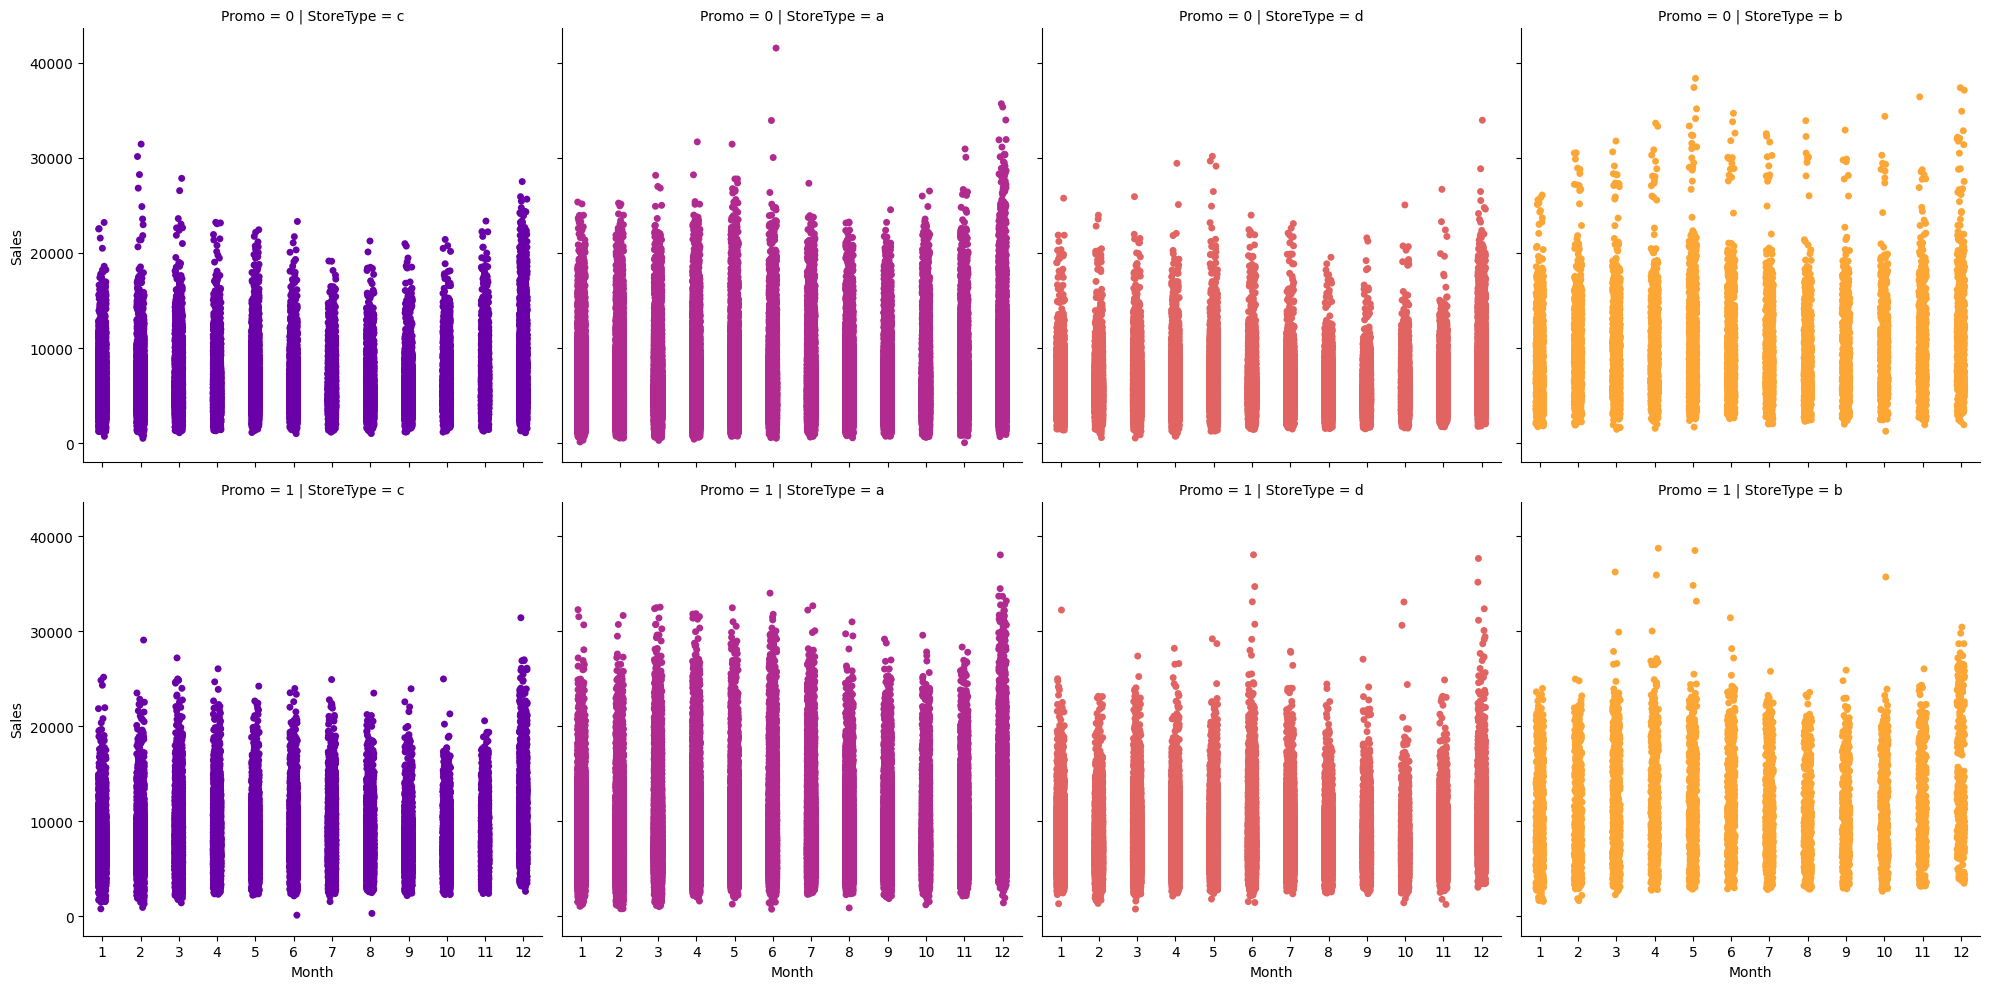

In [34]:
# sales trends
sns.catplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo') 

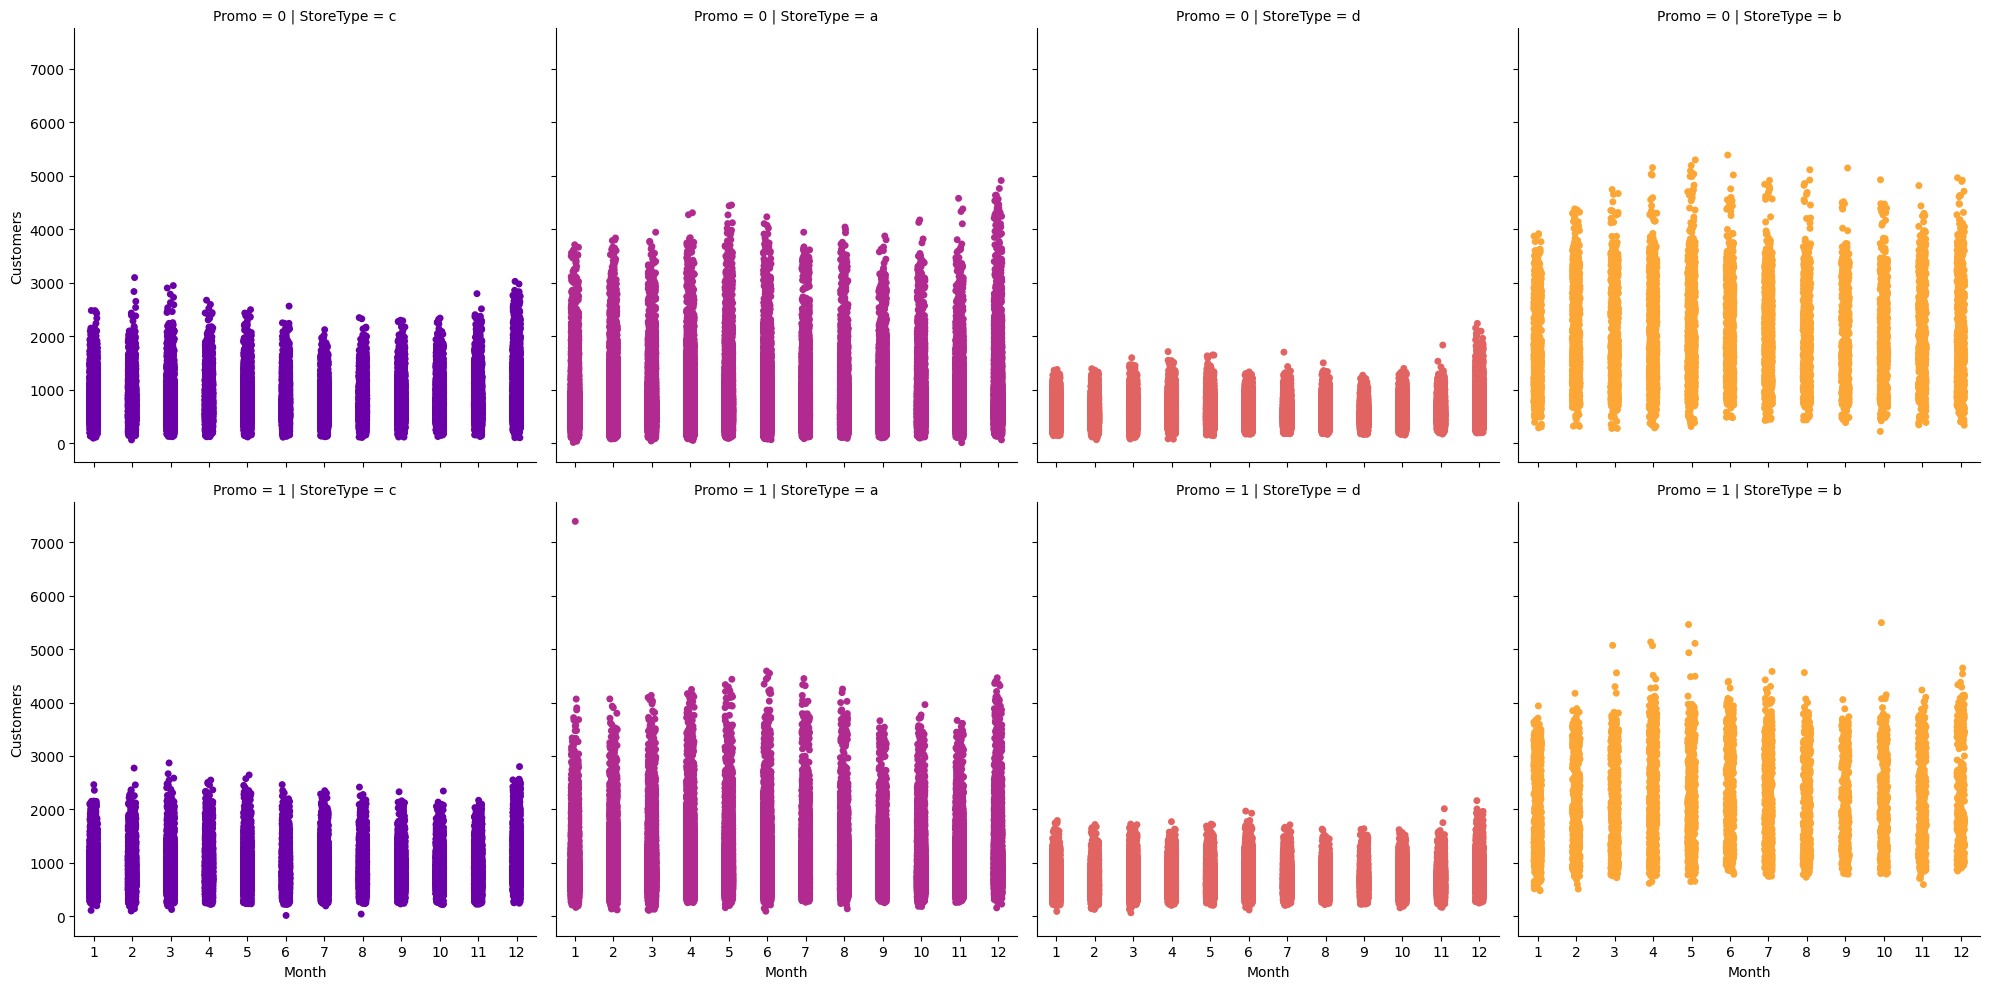

In [36]:
# sales trends
sns.catplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo') 

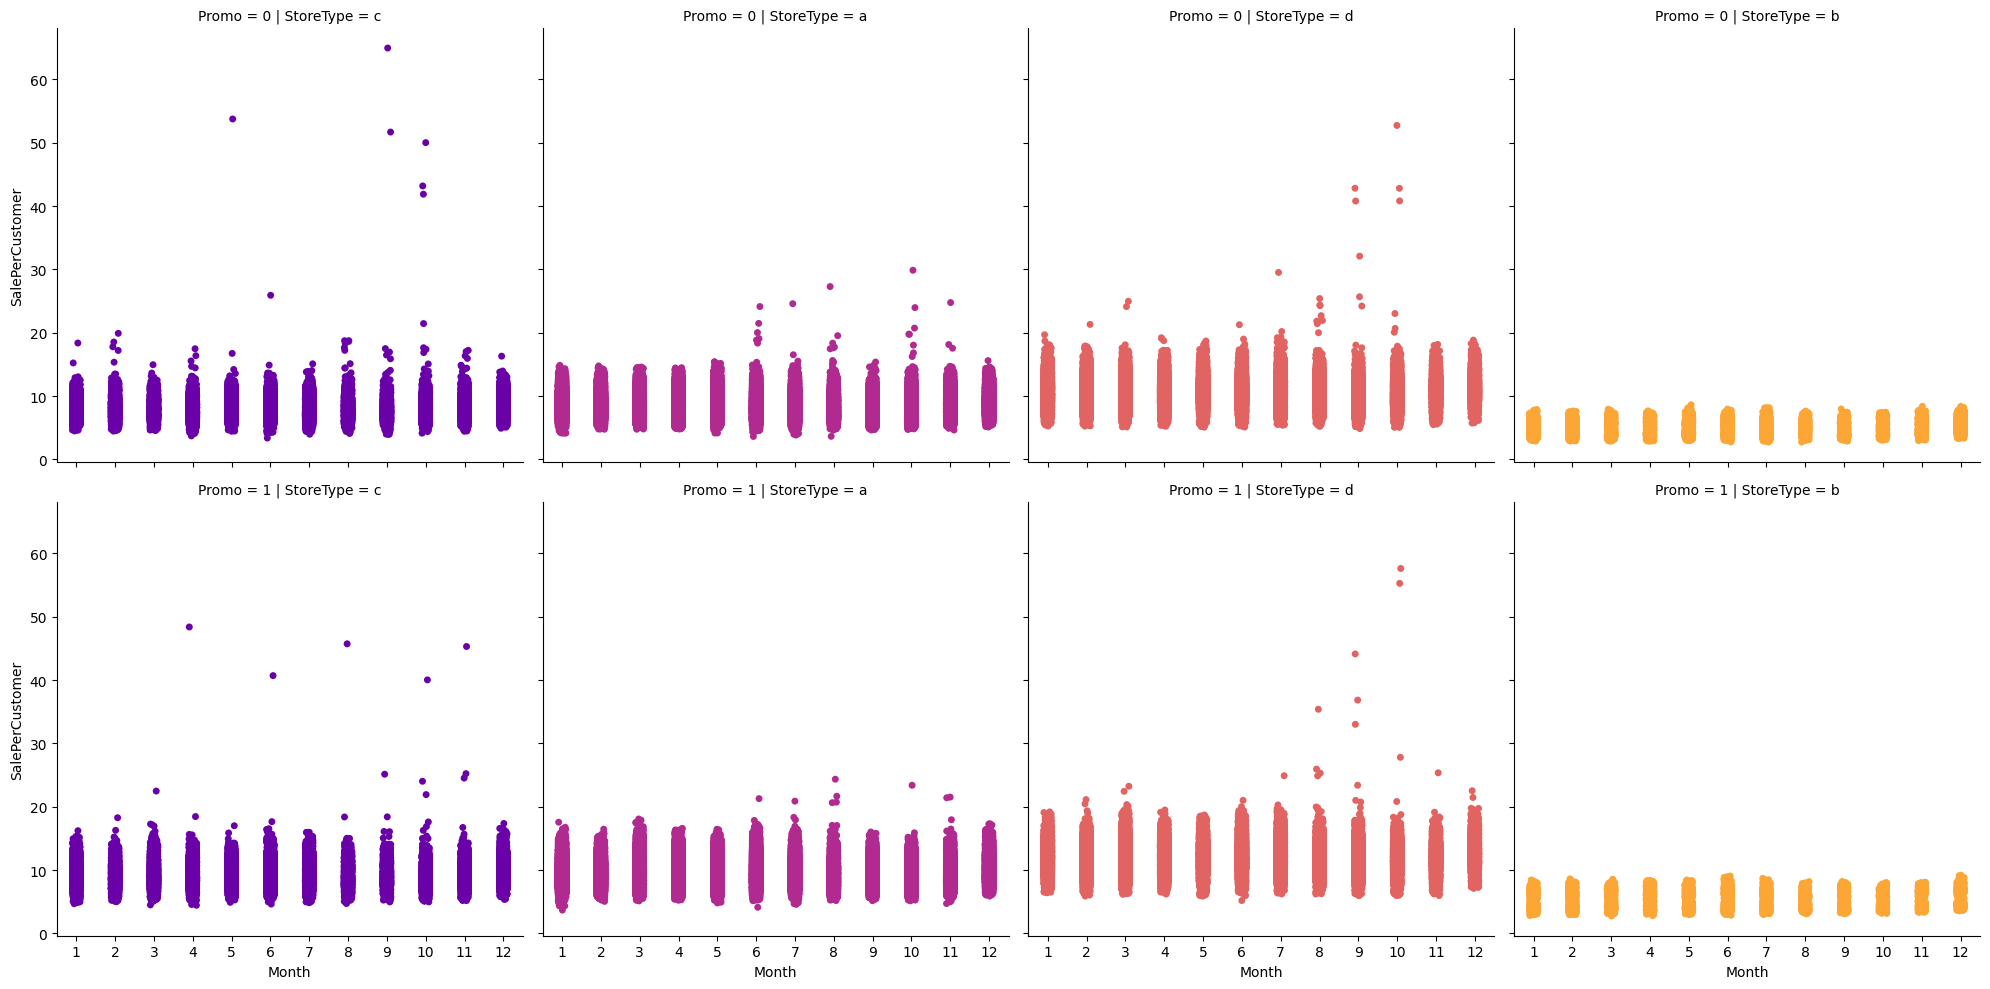

In [37]:
# sale per customer trends
sns.catplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

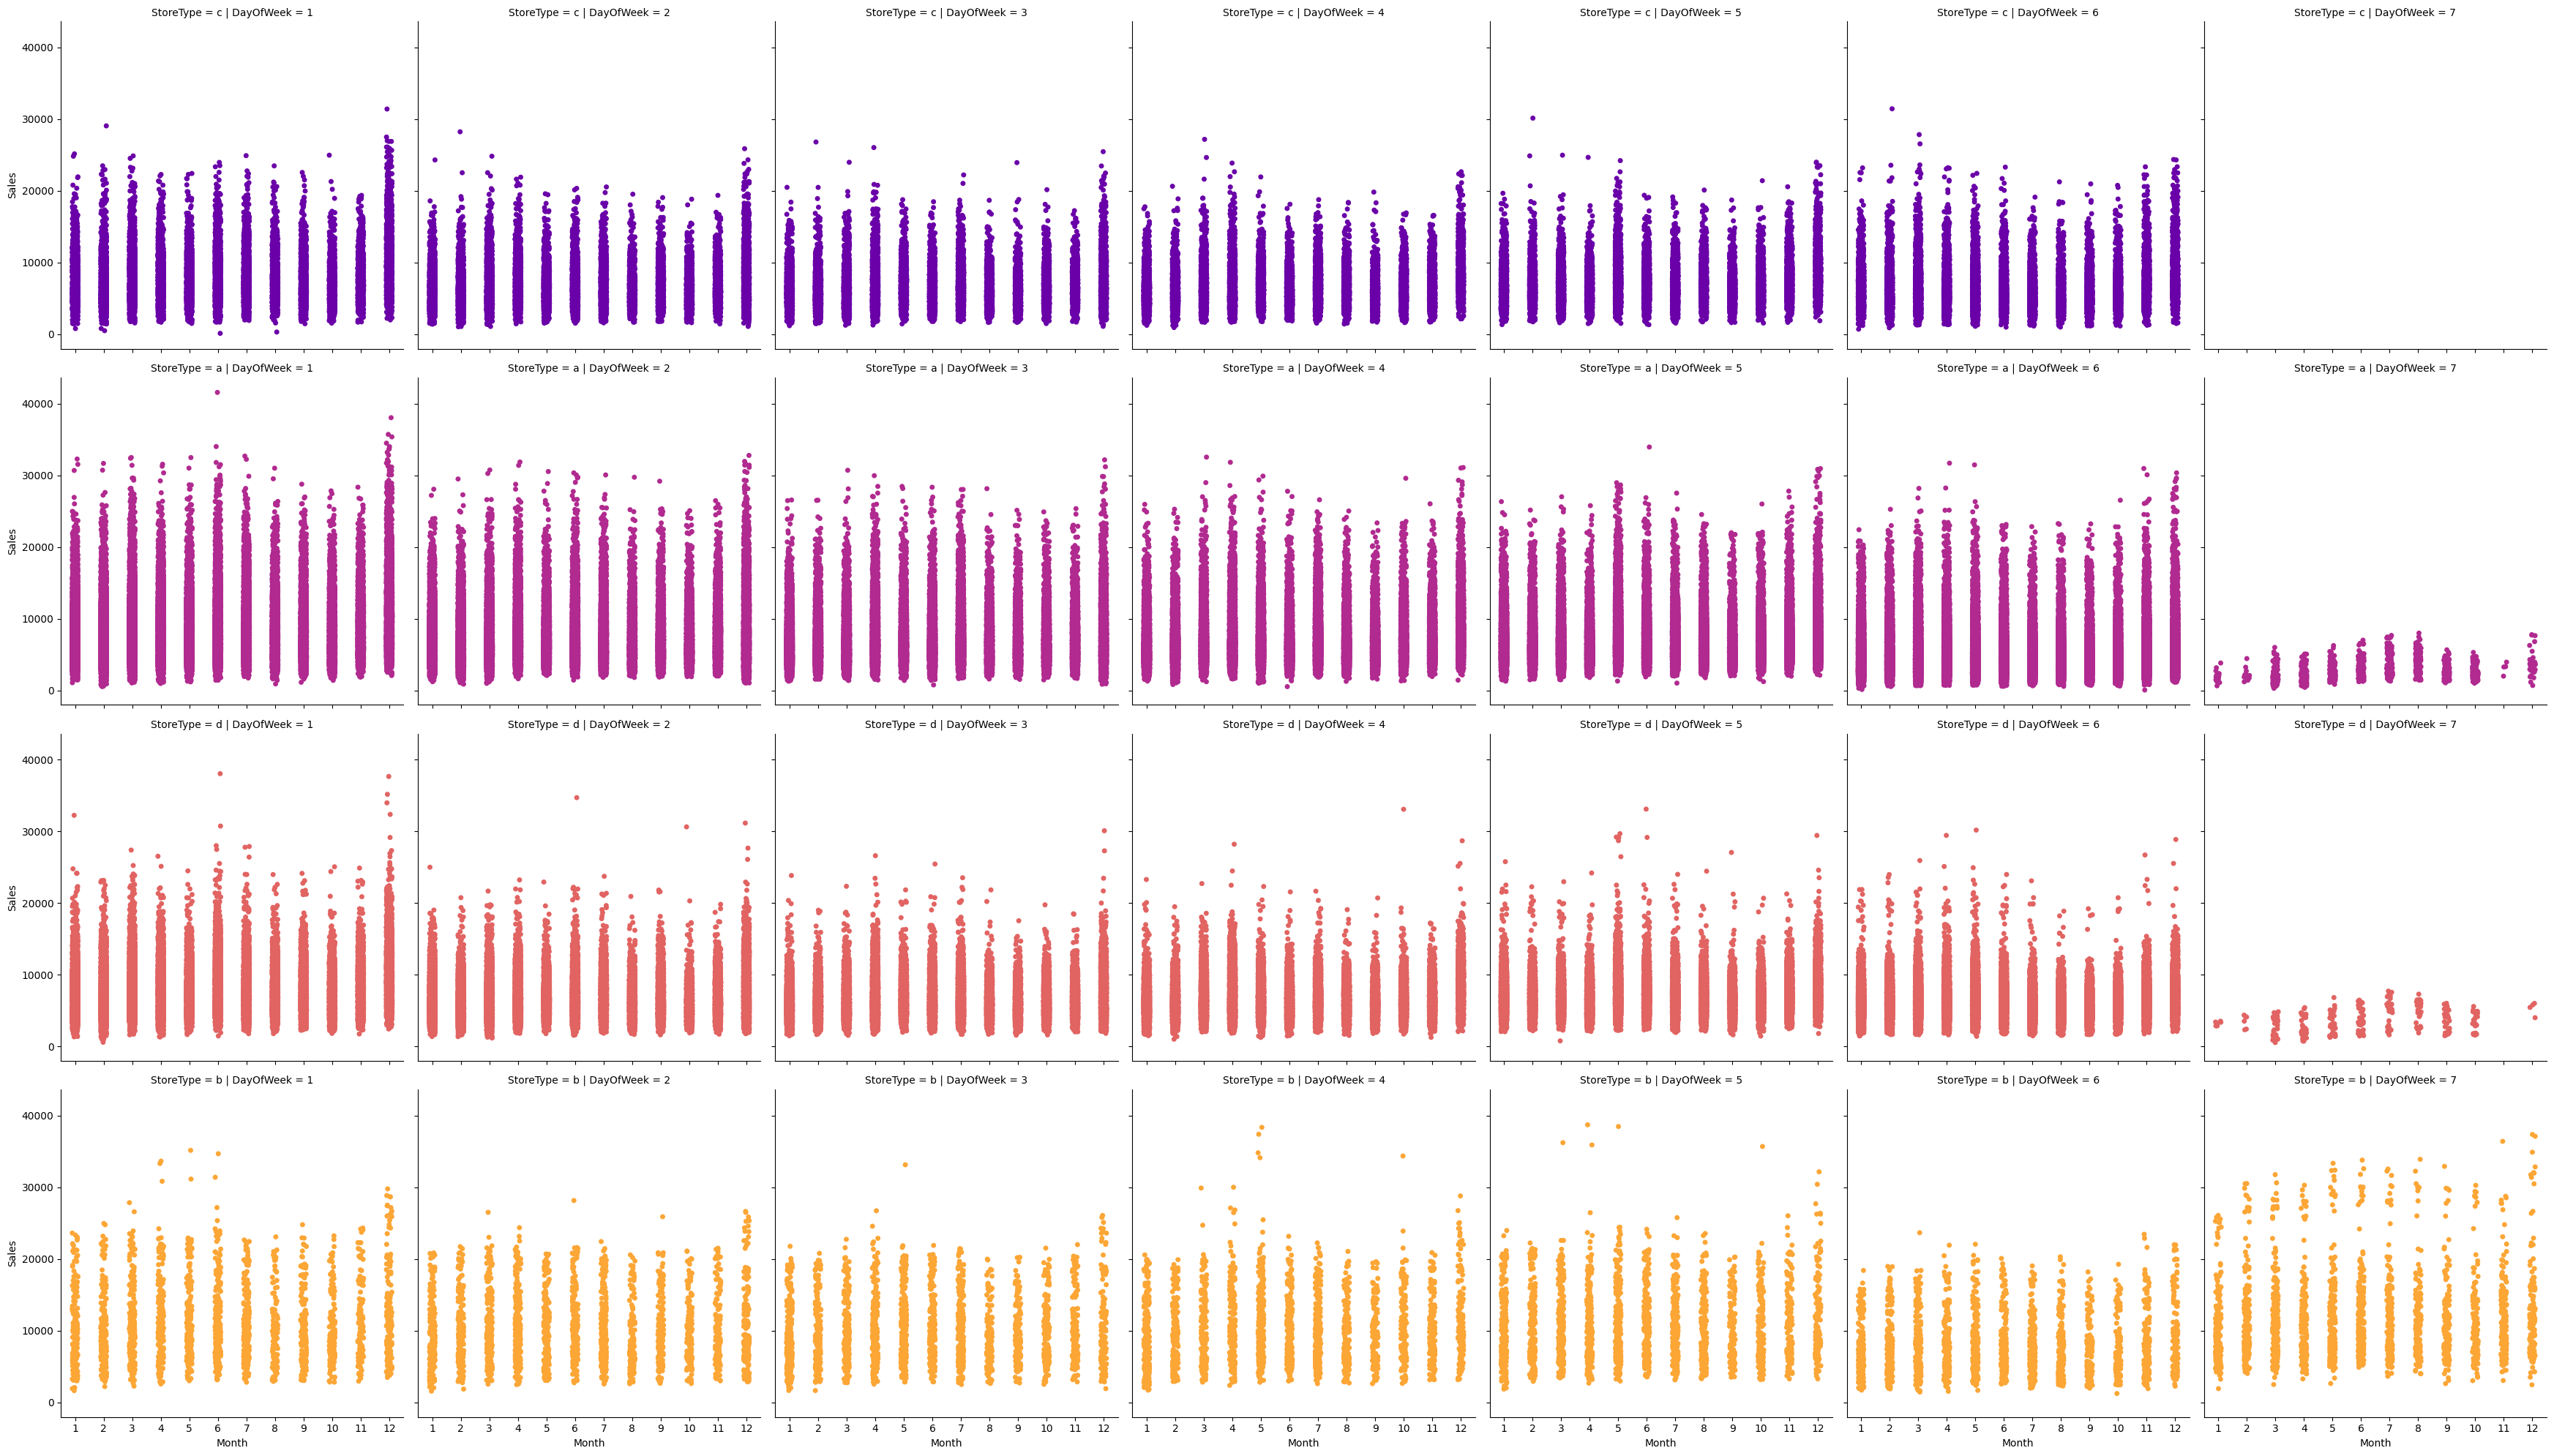

In [38]:
# customers
sns.catplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType')

Observation:
StoreType B has the longest running period of promotion.
It is noticed, StoreType B doesn't generate huge sale amount, but got the largest average sales.

In [39]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)  
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# test_store['CompetitionOpen'] = 12 * (test_store['Year'] - test_store['CompetitionOpenSinceYear']) + (test_store['Month'] - test_store['CompetitionOpenSinceMonth'])
# test_store['PromoOpen'] = 12 * (test_store['Year'] - test_store['Promo2SinceYear']) + (test_store['WeekOfYear'] - test_store['Promo2SinceWeek']) / 4.0


# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store[['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


Observation:
There is high relationship between Customers and Sales and Promo, but Promo2

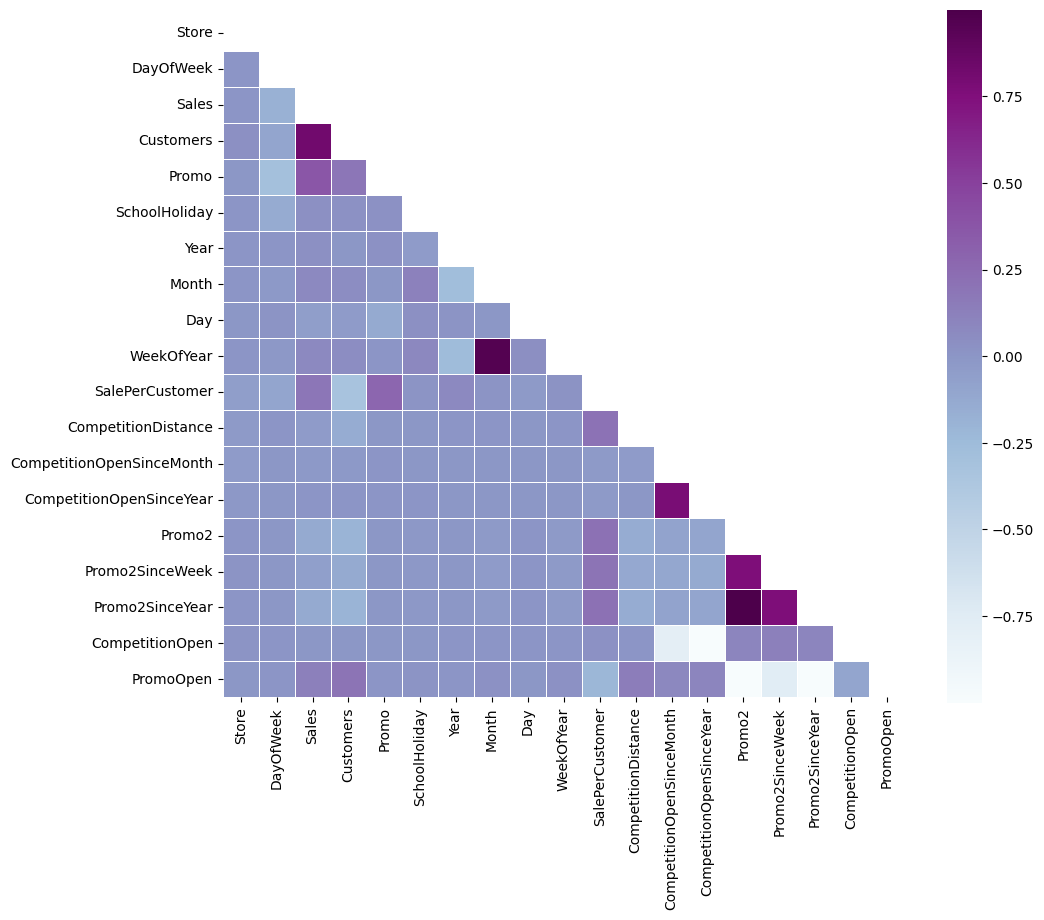

In [40]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()


Observation:
In the case of no promotion either Promo1 or Promo2, sale peaks on sunday.
On the contrary, store running Promo1 make the most of sale on monday.
Promo2 seems irrelevant to overal

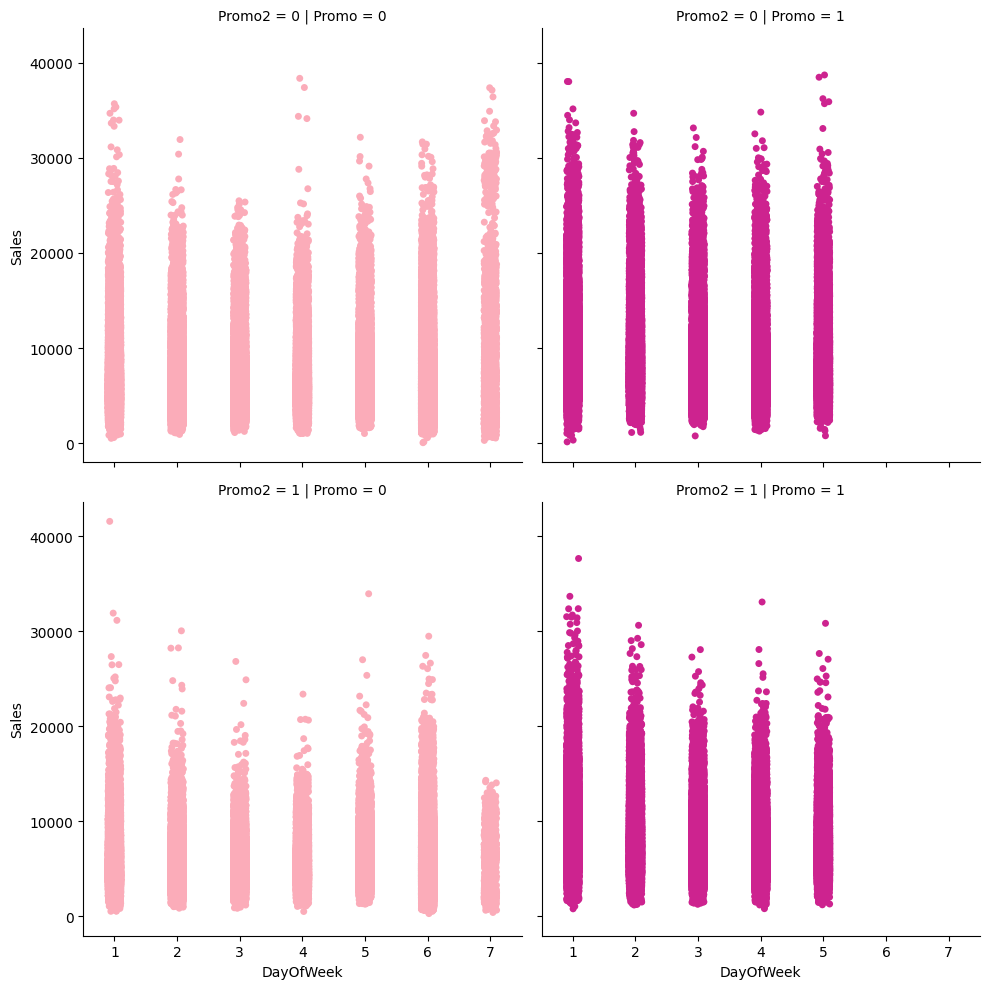

In [41]:
# sale per customer trends
sns.catplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo',   # SPECIAL
               palette = 'RdPu') 

DATA MANIPULATION

In [42]:
# to numerical
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}

train['StateHoliday'] = train['StateHoliday'].replace(mappings).astype('int64')

test['StateHoliday'] = test['StateHoliday'].replace(mappings).astype('int64')

store['StoreType'] = store['StoreType'].replace(mappings).astype('int64')
store['Assortment'] = store['Assortment'].replace(mappings).astype('int64')
store.drop('PromoInterval', axis = 1, inplace = True)

train_store = pd.merge(train, store, how = 'inner', on = 'Store')
test_store = pd.merge(test, store, how = 'inner', on = 'Store')

TIME SERIES ANALYSIS :-

Time series seems an alternative approach when dealing with continuous values, apart from ML regresions
Time in time series is dependant while target values is independant.
Seasonality, Trends, Residuals are 3 major things worth being explored in seasonal_decompose. Plus, some special event, holidays, ect, are captured as well.
Plotting ACF and PACF is the essential step before choosing which time series model is applyied, such as AR, MA, ARMA, ARIMA, SARIMA.
Prophet Facebook function is quite easy to use and is similar to ARIMA family.

Seasonal_decompose

In [43]:
# Choose 1 store with type a, namely store 2
sales_2 = train[train['Store'] == 2][['Sales', 'Date','StateHoliday','SchoolHoliday']]

In [44]:
sales_2['Date'].sort_index(ascending = False, inplace=True)

In [45]:
a = sales_2.set_index('Date').resample('W').sum()
a

,Sales,StateHoliday,SchoolHoliday
Date,,,
2013-01-06,23704,0,4
2013-01-13,26030,0,5
2013-01-20,29960,0,5
2013-01-27,28006,0,1
2013-02-03,35928,0,0
...,...,...,...
2015-07-05,26228,0,0
2015-07-12,27211,0,0
2015-07-19,23397,0,0


<Axes: xlabel='Date', ylabel='Sales'>

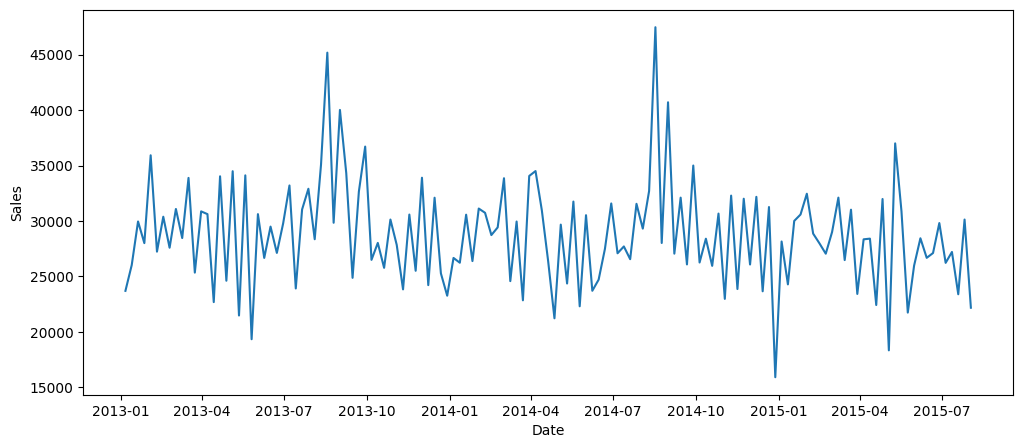

In [46]:
plt.figure(figsize=(12, 5))
sns.lineplot(x=a.index, y=a['Sales'])

Observation:
At the first glance, store 1 show stationary pattern.
Unfortunately, the trend experience downward.

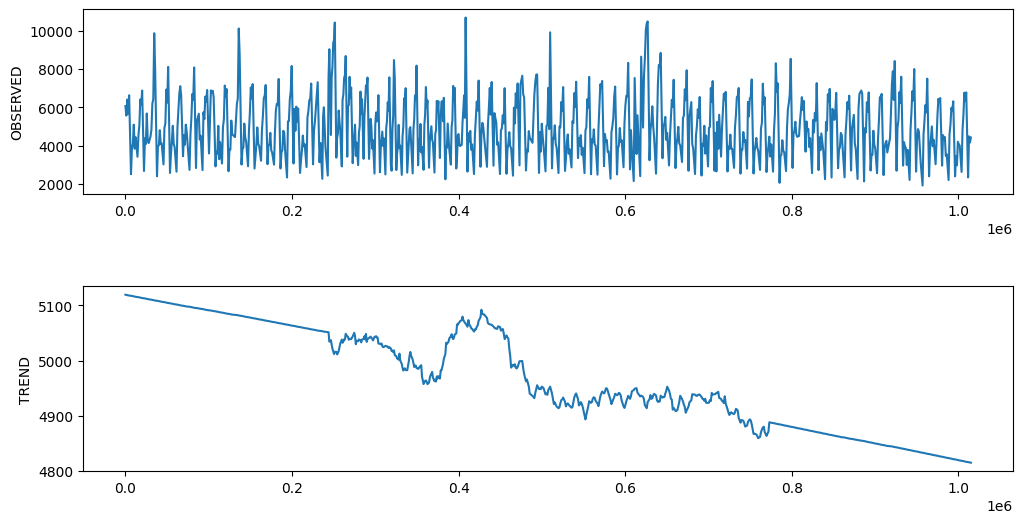

In [48]:
f, (ax1, ax2) = plt.subplots(2, figsize = (12, 6))

# monthly
decomposition_a = seasonal_decompose(sales_2['Sales'], model = 'additive', extrapolate_trend='freq', period=365)
decomposition_a.observed.plot(ax = ax1)
ax1.set_ylabel('OBSERVED')
decomposition_a.trend.plot(ax = ax2)
ax2.set_ylabel('TREND')
f.subplots_adjust(hspace = 0.5)


Autocorrelaion


Observation:
ACF is a measure of the correlation between the timeseries with a lagged version of itself. I choose lags of 50. ACF help us choose MA model.
PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself, after removing the influence of any variance in the middle. PACF helps us choose AR model.
Looking at the Autocorrelation graph shows store 1 has high seasonality at 12 lags, it experienced positive spike at 12 lags, 24 lags,... This store show high correlation between the current time unit with the previous time unit.

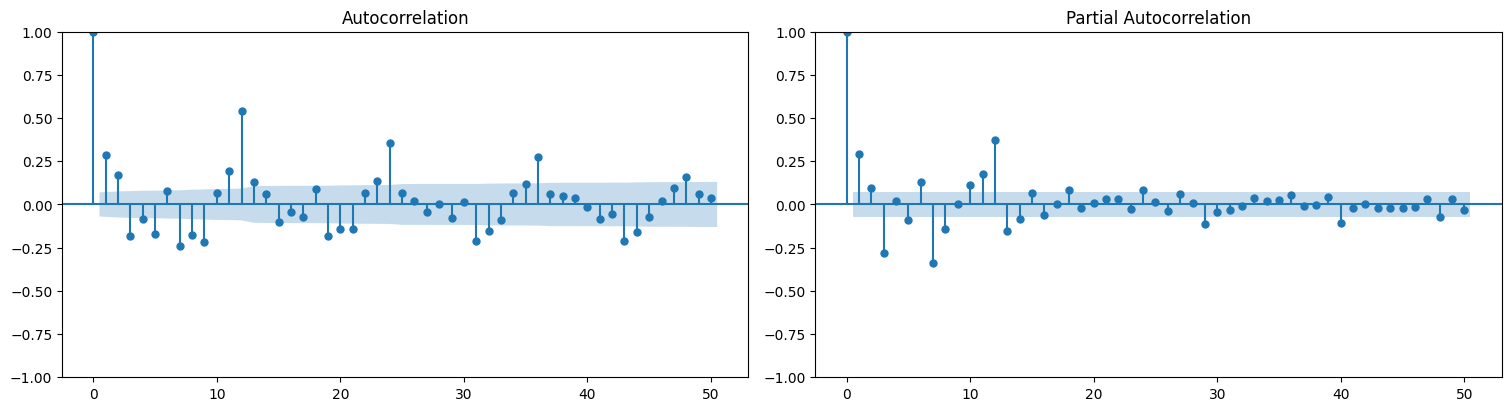

In [49]:
fig = plt.figure(constrained_layout=True, figsize=(15, 4))
grid = gridspec.GridSpec(nrows=1, ncols=2,  figure=fig)

# acf and pacf for A
ax1 = fig.add_subplot(grid[0, 0])
plot_acf(sales_2['Sales'], lags = 50, ax=ax1);

# acf and pacf for A
ax1 = fig.add_subplot(grid[0, 1])
plot_pacf(sales_2['Sales'], lags = 50, ax=ax1);

plt.show();

TIME SERIES MODELS  ❎

ARIMA FAMILY FORECASTING ⛔



In [50]:
# adfuller helps us to determine the right model for analysis. 
# For example, the returned value from adf_test show 'Fail to reject the null hypothesis', it means we should make differencing.

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [51]:
adf_test(sales_2['Sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.292708
p-value                   0.000006
# lags used              17.000000
# observations          766.000000
critical value (1%)      -3.438916
critical value (5%)      -2.865321
critical value (10%)     -2.568783
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [52]:
x = sales_2.set_index('Date').loc[:'2015-06-30']
y = sales_2.set_index('Date').loc['2015-07-01':]

In [54]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 54.4 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.5
    Uninstalling statsmodels-0.13.5:
      Successfully uninstalled statsmodels-0.13.5


AR Model

In [56]:
import statsmodels.tsa.ar_model as ar_model

In [59]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

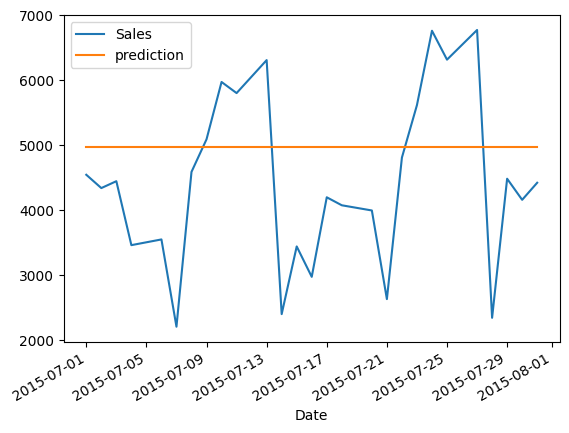

Root Mean Squared Error:  1415.7818265115893


In [61]:
model = sm.tsa.arima.ARIMA(x['Sales'])
AR1fit = model.fit()
#print(f'Lag: {AR1fit.k_ar}')
#print(f'Coefficients:\n{AR1fit.params}')

# This is the general format for obtaining predictions
start=len(x)
end=len(x)+len(y)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False)

predictions1.index = y.index

y['Sales'].plot()
predictions1.plot(label='prediction');
plt.legend()
plt.show()

print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(y['Sales'], predictions1)))

ARMA Mode

In [62]:
# auto_arima help us choose the optimal model, sometime manually tweaking model hyperparameters yeild better result.
auto_arima(x['Sales'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  757
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -6597.707
Date:                Fri, 02 Jun 2023   AIC                          13209.414
Time:                        13:38:04   BIC                          13241.819
Sample:                             0   HQIC                         13221.895
                                - 757                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4397.3565    286.592     15.344      0.000    3835.647    4959.066
ar.L1          0.2923      0.037      7.830      0.000       0.219       0.365
ar.L2          0.1348      0.042      3.232      0.001       0.053       0.217
ar.L3         -0.2687      0.043     -6.314      0.000      -0.352      -0.185
ar.L4          0.0486      0.042      1.147      0.252      -0.034       0.132
ar.L5         -0.0918      0.037     -2.507      0.012      -0.163      -0.020
sigma2      2.184e+06   1.09e+05     20.104      0.000    1.97e+06     2.4e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 2.08
Prob(Q):                              0.73   Prob(JB):                         0.35
Heteroskedasticity (H):               0.79   Skew:                            -0.04
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.2e+23. Standard errors may be unstable.

In [65]:
# Adding exorgenous variable may help accuracy improvement. Let's see
# It doesnt improve as the store usually closed on StateHoliday or SchoolHoliday and sales may not escalated even if it opens.
auto_arima(x['Sales'], exorgenous=x[['StateHoliday','SchoolHoliday']],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  757
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -6597.707
Date:                Fri, 02 Jun 2023   AIC                          13209.414
Time:                        13:40:06   BIC                          13241.819
Sample:                             0   HQIC                         13221.895
                                - 757                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4397.3565    286.592     15.344      0.000    3835.647    4959.066
ar.L1          0.2923      0.037      7.830      0.000       0.219       0.365
ar.L2          0.1348      0.042      3.232      0.001       0.053       0.217
ar.L3         -0.2687      0.043     -6.314      0.000      -0.352      -0.185
ar.L4          0.0486      0.042      1.147      0.252      -0.034       0.132
ar.L5         -0.0918      0.037     -2.507      0.012      -0.163      -0.020
sigma2      2.184e+06   1.09e+05     20.104      0.000    1.97e+06     2.4e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 2.08
Prob(Q):                              0.73   Prob(JB):                         0.35
Heteroskedasticity (H):               0.79   Skew:                            -0.04
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.2e+23. Standard errors may be unstable.

SARIMA Model

In [66]:
# As we talk above, we may be interested in the fact that event or seasonality can influence sale of store.
# However, in this case, adding seasonality worsen model. Thus, there is no clear seasonal component in this case.

# https://alkaline-ml.com/pmdarima/tips_and_tricks.html#setting-m
# m = 7(daily), 12(monthly), 52(weekly)
auto_arima(x['Sales'],seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  757
Model:             SARIMAX(4, 0, 4)x(0, 0, [1, 2], 7)   Log Likelihood               -6527.569
Date:                                Fri, 02 Jun 2023   AIC                          13079.138
Time:                                        13:45:07   BIC                          13134.690
Sample:                                             0   HQIC                         13100.534
                                                - 757                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6096.8860   2961.808      2.059      0.040     291.849    1.19e+04
ar.L1          0.3178      0.287      1.106      0.269      -0.245       0.881
ar.L2         -0.0415      0.043     -0.973      0.330      -0.125       0.042
ar.L3         -0.8786      0.035    -24.994      0.000      -0.948      -0.810
ar.L4          0.3762      0.261      1.440      0.150      -0.136       0.888
ma.L1         -0.0425      0.303     -0.140      0.889      -0.637       0.552
ma.L2          0.1796      0.096      1.862      0.063      -0.009       0.369
ma.L3          0.7582      0.083      9.094      0.000       0.595       0.922
ma.L4         -0.2270      0.259     -0.876      0.381      -0.735       0.281
ma.S.L7       -0.3058      0.049     -6.277      0.000      -0.401      -0.210
ma.S.L14       0.0902      0.046      1.942      0.052      -0.001       0.181
sigma2       1.99e+06   9.84e+04     20.226      0.000     1.8e+06    2.18e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                63.85
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.47
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Root Mean Squared Error:  1178.0944803307423


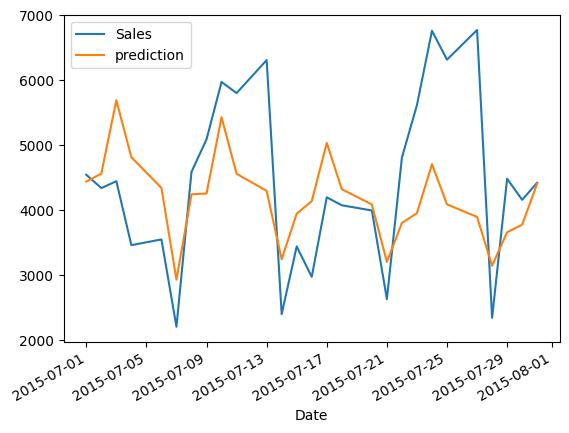

In [67]:
model = SARIMAX(x['Sales'],order=(5, 0, 3),seasonal_order=(0, 0, 1, 7))
results = model.fit()

start=len(x)
end=len(x)+len(y)-1
predictions1 = results.predict(start=start, end=end, dynamic=False)

predictions1.index = y.index

y['Sales'].plot()
predictions1.plot(label='prediction');
plt.legend()

print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(y['Sales'], predictions1)))

REGRESSION MODELS

In [68]:
train_store['CompetitionOpen'] = 12 * (train_store['Year'] - train_store['CompetitionOpenSinceYear']) + (train_store['Month'] - train_store['CompetitionOpenSinceMonth'])
train_store['PromoOpen'] = 12 * (train_store['Year'] - train_store['Promo2SinceYear']) + (train_store['WeekOfYear'] - train_store['Promo2SinceWeek']) / 4.0

test_store['CompetitionOpen'] = 12 * (test_store['Year'] - test_store['CompetitionOpenSinceYear']) + (test_store['Month'] - test_store['CompetitionOpenSinceMonth'])
test_store['PromoOpen'] = 12 * (test_store['Year'] - test_store['Promo2SinceYear']) + (test_store['WeekOfYear'] - test_store['Promo2SinceWeek']) / 4.0

In [69]:
# Sorting dataframe according to datatime, the oldest is on top, the most recent is at the bottom.
train_store['Date'].sort_index(ascending = False, inplace=True)

In [70]:
def rmsle(y_pred, y):
    return np.sqrt(mean_squared_error(y_pred, y))

def model_check (estimators):
    model_table = pd.DataFrame()
    row_index = 0
    
    for est in estimators:
        MLA_name = est.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name
        
        est.fit(x_train, y_train)
        y_pred = est.predict(x_test)
        model_table.loc[row_index, 'Test Error'] = rmsle(y_pred, y_test)
        
        row_index += 1
        
        model_table.sort_values(by=['Test Error'],
                            ascending=True,
                            inplace=True)
    return model_table

In [71]:
# MODELS
lr = LinearRegression()
ls = Lasso()
GBoost = GradientBoostingRegressor(random_state = 0)
XGBoost = XGBRegressor(random_state = 0, n_job=-1)
LGBM = LGBMRegressor(random_state = 0, n_job=-1)

In [72]:
# Training dataset is separated into train_a and test_a.
# traing_a train data from 2013 till 2015-06-30, while test_a contain  data from 2015-07-01 till 2015-07-31.

train_a = train_store.set_index('Date').loc[:'2015-06-30']
test_a = train_store.set_index('Date').loc['2015-07-01':]

x_train = train_a.drop(['Sales', 'Customers'], axis=1)
y_train = train_a['Sales']
x_test = test_a.drop(['Sales', 'Customers'], axis=1)
y_test = test_a['Sales']

In [73]:
estimators = [lr, ls, GBoost, XGBoost, LGBM]
model_check(estimators)

[14:02:44] WARNING: ../src/learner.cc:767: 
Parameters: { "n_job" } are not used.

[LightGBM] [Warning] Unknown parameter: n_job


,Model Name,Test Error
3,XGBRegressor,1079.952905
4,LGBMRegressor,1616.072804
2,GradientBoostingRegressor,2272.147321
0,LinearRegression,2672.310857
1,Lasso,2672.421082


In [74]:
# This part is different from the above. This particularly examinze the prediction power on store 2 only.

train_a = train_store[train_store['Store']==2].set_index('Date').loc[:'2015-06-30']
test_a = train_store[train_store['Store']==2].set_index('Date').loc['2015-07-01':]

x_train = train_a.drop(['Sales', 'Customers','SalePerCustomer'], axis=1)
y_train = train_a['Sales']
x_test = test_a.drop(['Sales', 'Customers', 'SalePerCustomer'], axis=1)
y_test = test_a['Sales']

In [75]:
XGBoost = XGBRegressor(random_state = 0, n_job=-1).fit(x_train, y_train)
y_pred = XGBoost.predict(x_test)
LGBM = LGBMRegressor(random_state = 0, n_job=-1).fit(x_train, y_train)
y_pred = LGBM.predict(x_test)

[14:04:38] WARNING: ../src/learner.cc:767: 
Parameters: { "n_job" } are not used.

[LightGBM] [Warning] Unknown parameter: n_job


Observation:
Seeing both feature importance of XGBoost and LightGBM show similar patterns.
Day, DayOfWeek, WeekOfYear, PromoOpen, Promo primarily account for sale amount

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

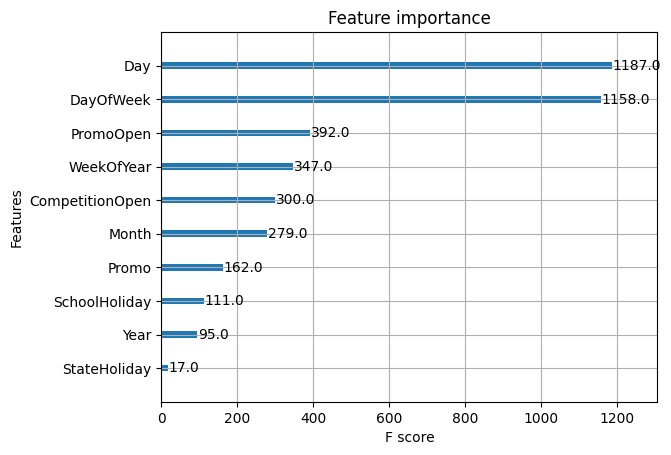

In [76]:
xgb.plot_importance(XGBoost)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

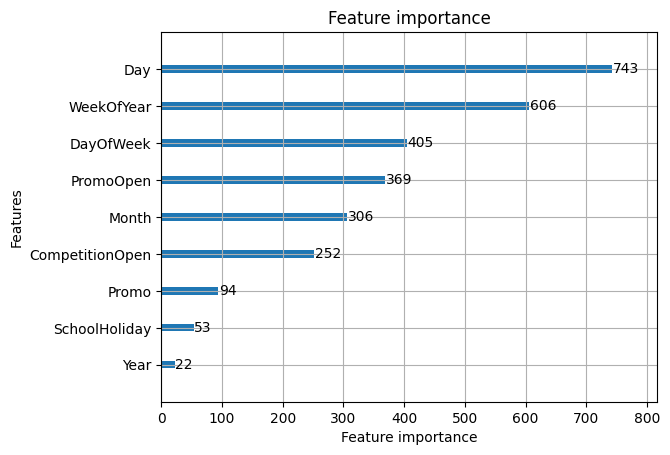

In [77]:
lightgbm.plot_importance(LGBM)